In [1]:
import feather

from math import log

import numpy as np
import pandas as pd

from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = '../data/processed/EDY/holdings_summary_s_s.feather'
summary = feather.read_dataframe(path)
summary.shape

(18383, 10)

In [3]:
### Load the data files

path = '../data/processed/EDY/holdings_s_s.npz'
holdings = sparse.load_npz(path)

path = '../data/processed/EDY/holdings_b.npz'
holdings_b = sparse.load_npz(path)

print(holdings.shape)
print(holdings_b.shape)

(18383, 722)
(35791, 722)


In [4]:
holdings = holdings
holdings_b = holdings_b

In [5]:
port_number = holdings.shape[0]
port_number

18383

## Analysis

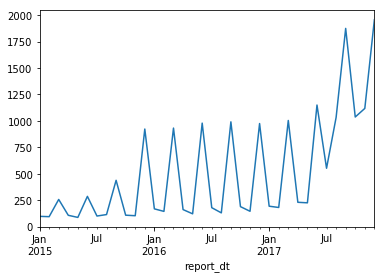

In [6]:
summary.groupby('report_dt')['index'].count().plot()

# Average Portfolio per report_dt

In [7]:
holdings_d = pd.DataFrame(holdings.toarray())
holdings_d = holdings_d.astype(int)

In [8]:
holdings_d = holdings_d.groupby(summary['report_dt']).rolling(2).mean()

In [9]:
holdings_d['report_dt'] = summary['report_dt']

In [10]:
holdings_d = holdings_d.set_index('report_dt')

In [11]:
holdings_d = holdings_d.resample('Q', label='right', closed='right').mean()

AttributeError: 'NaTType' object has no attribute 'normalize'

In [ ]:
plt.plot(holdings_d.mean().sort_values().values)


# Old IDF TF calc

### Round to int

In [12]:
holdings.data = holdings.data.round().astype(int)

## Calc IDF

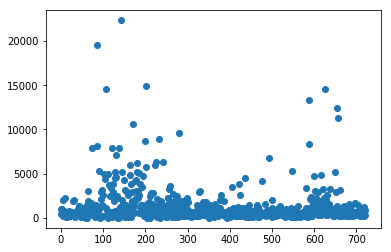

In [13]:
col_sum = holdings[:,:].sum(0).T
plt.plot(col_sum, 'o')

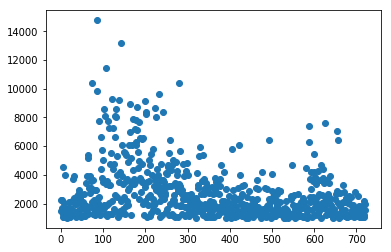

In [14]:
col_sum_b = holdings_b.sum(0).T
plt.plot(col_sum_b,'o')

In [15]:
def IDF_calc(x,port_number):
    return 1 + log(port_number / (x))
IDF_calc = np.vectorize(IDF_calc)

IDFs = IDF_calc(col_sum_b,port_number)

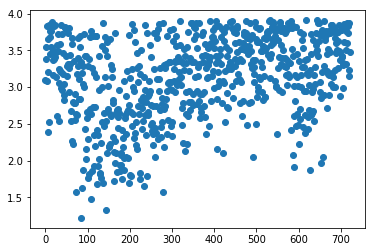

In [16]:
plt.plot(IDFs,'o')

## Multiply IDF with TF

In [19]:
IDFs_matrix = np.tile(IDFs.T,(port_number,1))

In [20]:
IDFs_matrix.shape

(18383, 722)

In [21]:
holdings.shape

(18383, 722)

In [22]:
holdings_transformed = holdings.multiply(IDFs_matrix).tocsr()

In [23]:
holdings_transformed

<18383x722 sparse matrix of type '<class 'numpy.float64'>'
	with 1017706 stored elements in Compressed Sparse Row format>

## PCA

In [24]:
from sklearn.decomposition import TruncatedSVD

In [25]:
X = holdings_transformed.T
svd = TruncatedSVD(n_components=100)
svd.fit(X)  

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)

In [26]:
holdings_transformed = svd.components_

In [27]:
print(svd.explained_variance_ratio_)  
print()
print(svd.explained_variance_ratio_.sum())  


[0.16958227 0.12821575 0.11566701 0.04782648 0.02848757 0.00906215
 0.00772085 0.00701594 0.00609365 0.00575505 0.00555664 0.0049637
 0.00503221 0.00489814 0.00454632 0.0043051  0.00396838 0.00379985
 0.00357691 0.00343292 0.00334773 0.0032885  0.00320618 0.00314896
 0.0030873  0.00304357 0.00301499 0.00295103 0.0028499  0.00281063
 0.00277511 0.00272702 0.00270326 0.00264439 0.00260705 0.00255982
 0.00249986 0.00246394 0.00241683 0.00238966 0.00235584 0.00233047
 0.00229558 0.00225376 0.00223093 0.00222299 0.00220348 0.00216811
 0.00215207 0.00211029 0.00206409 0.00205381 0.00203341 0.00201374
 0.0019994  0.0019809  0.00194386 0.00193262 0.00192782 0.00190416
 0.00189626 0.00187932 0.00183167 0.00181207 0.00179723 0.00178235
 0.00176827 0.00176091 0.00175638 0.00172288 0.0017174  0.00169548
 0.00167386 0.00166013 0.00164796 0.00164037 0.00162483 0.00161909
 0.00160183 0.00158907 0.00157462 0.00155428 0.00153231 0.00152968
 0.00151648 0.00151708 0.00149635 0.00148126 0.00147872 0.00147

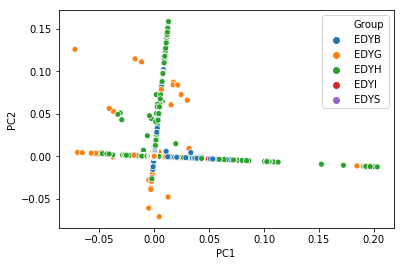

In [28]:
result_mat = pd.DataFrame({'PC1': svd.components_[1], 'PC2':svd.components_[0], 'Group': summary['crsp_obj_cd']})

sns.scatterplot('PC1','PC2', hue='Group', data = result_mat)

In [30]:
holdings_transformed = pd.DataFrame(holdings_transformed).T

## Save

In [27]:
### Load the data files
path = '../data/processed/EDY/holdings_s_lsa.npz'
feather.write_dataframe(holdings_transformed,path)